# Assignment 1 - Jan Zimmermann
Folgendes Jupiter Notebook kombiniert die Daten unterschiedlichen Datenquellen, um die beste Gemeinde des Kantons Schaffhausen zu bestimmen. Dabei werden drei unterschiedliche Kategorien untersucht:
1. Alterstatistik: Welche Gemeinde hat prozentual die beste Verteilung der Einwohner bezüglich der Altersklassen?
2. Weinstatistik: Welche Gemeinde baut am meisten Reben der Sorten Blauburgunder, Chardonnay und Sauvignon blanc an?
3. Bildungslast Statistik: Welche Gemeinde weist die tiefste Bildungslast der vergangenen Jahren auf?

In [1]:
import pandas as pd
import requests
from io import StringIO
from bs4 import BeautifulSoup
import tabula
import seaborn as sns
import matplotlib.pyplot as plt

import warnings

# Ignoriere die FutureWarning-Meldung
warnings.filterwarnings("ignore", category=FutureWarning)

/var/folders/xy/0br9tjv92ygfx1xdz070c1l40000gn/T/ipykernel_75620/571151951.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Hier werden diverse Funktionen deklariert, welche öfters wiederverwendet wurden

# Plot des Balkendiagramms
def showBarDiagramWithValues(dataframe_to_display, bar_title, y_start_point):
    plt.rcParams['figure.figsize'] = [10, 6]
    bar_diagram_axis = dataframe_to_display.plot(kind='bar', x='Gemeinde')
    bar_diagram_axis.set_ylabel('Punktzahl')
    bar_diagram_axis.set_xlabel('Gemeinden')
    bar_diagram_axis.set_title(bar_title)
    bar_diagram_axis.set_ylim(y_start_point, None)
    plt.xticks(rotation=45)
    plt.legend(title='Kategorien')

    # Stelle die Werte für jede Säule dar
    for i in bar_diagram_axis.patches:
        bar_diagram_axis.text(i.get_x() + i.get_width() / 2, i.get_height() + 2, str(round(i.get_height(), 1)), ha='center', va='bottom', rotation=45)

    plt.show()

# Berechne die relative Punkte zu dem min / max Wert der definierten Spalten
def calculatePointsForColumns(dataframe, dataframe_colums):
    tmp = dataframe.copy()
    for col in dataframe_colums:
        min_value = tmp[col].min()
        max_value = tmp[col].max()
        tmp[f'Punkte {col}'] = ((tmp[col] - min_value) / (max_value - min_value)) * 100
    return tmp

# Bereinige gegebenes DataFrame, selektiere angegebene Spalten und sortiere eine dieser Spalten absteigend
def cleanUpDataFrameOnColumns(dataframe, columns, sortBy):
    tmp = dataframe.copy().iloc[:, columns]
    tmp = tmp.fillna(0)
    tmp = tmp.sort_values(by=sortBy, ascending=False)
    return tmp

### Gemeindestatistik - Source of truth
Die Gemeindestatistik bildet die übergeordnete Datensammlung. Diese Datenbasis gilt als `source of truth`, sofern es Abweichungen gibt der Gemeindenamen bei anderen Statistiken gibt, behält diese Statistik stets die Oberhand.

*Quellen*: 
- http://de.wikipedia.org/wiki/Gemeinden_des_Kantons_Schaffhausen
Laden der Gemeindenamen als `source of truth`

In [3]:
url = 'http://de.wikipedia.org/wiki/Gemeinden_des_Kantons_Schaffhausen'

# Lade den HTML-Code der Wikipedia-Seite
response = requests.get(url)
html_content = response.content

# Verwende BeautifulSoup, um die Tabelle der Gemeinden zu extrahieren
soup = BeautifulSoup(html_content, 'html.parser')
communities_html_table = str(soup.find('table'))

# Verwende Pandas, um die Tabelle in ein DataFrame zu konvertieren
dataframe_communities = pd.read_html(StringIO(communities_html_table))[0] 
dataframe_communities = dataframe_communities.iloc[:, [1,3,5]]
dataframe_communities = dataframe_communities.drop(len(dataframe_communities)-1).reset_index(drop=True)
dataframe_communities.columns = ['Gemeinde', 'Fläche (km²)', 'Bezirk']
dataframe_communities['Gemeinde'] = dataframe_communities['Gemeinde'].str.replace(" (SH)", '')

### Altersstatistik pro Gemeinde
Die Alterstatistik zeit auf wie die Bevölkerung der einzelnen Gemeinden auf die Altersgruppen verteilt werden. Analysiert werden die Altersgruppen `0 – 19 Jahre`, `20 – 64 Jahre`, `65 – 79 Jahre` und `über 80 Jahre`. Wobei die Bevölkerung `über 80 Jahren` nicht mehr berücksichtigt werden.

*Quellen*: 
- https://image.shkb.ch/dynamic/noop/387c5e5dc5b11b214cd0f1397cb34ceba3aa91eb/kanton-schaffhausen-in-zahlen-1.pdf, Seite 12 - 13, Jahr 23/24: Laden der Anzahl Personen pro Altersgruppe und das Total der Einwohner pro Gemeinde.

In [4]:
# Pfadeingabe zum PDF
pdf_path = "data/kanton-schaffhausen-in-zahlen.pdf"

# Lese das PDF in ein Pandas DataFrame ein
dataframe_population_raw = tabula.read_pdf(pdf_path, pages='all', multiple_tables=True)[7]
dataframe_population_raw = dataframe_population_raw.drop(0).reset_index(drop=True)
dataframe_population_raw.columns = ['Gemeinde', 'Total Einwohner', 'Schweizerinnen und Schweizer', 'Ausländerinnen und Ausländer', '0 – 19 Jahre', '20 – 64 Jahre', '65 – 79 Jahre', 'über 80 Jahre']

# Liste der Spalten, die bearbeitet werden sollen
population_columns = ['Total Einwohner', 'Schweizerinnen und Schweizer', 'Ausländerinnen und Ausländer', '0 – 19 Jahre', '20 – 64 Jahre', '65 – 79 Jahre', 'über 80 Jahre']

# Iteriere über die ausgewählten Spalten und parse den Wert zu einem nummerischen Wert
for column in population_columns:
    try:
        dataframe_population_raw[column] = pd.to_numeric(dataframe_population_raw[column].str.replace('\'', ''), errors='ignore')
    except ValueError as e:
        print(f"Error converting column '{column}': {e}")
        
dataframe_population_raw = dataframe_population_raw.fillna(0)

Error importing jpype dependencies. Fallback to subprocess.
No module named 'jpype'


In [5]:
# Zusammenführen der Gemeindenamen Daten und der Altersstatistik von Schauffhausen
# Berechne die prozentuale Verteilung pro Gemeinde und Altersgruppe zu der Gesamt Einwohnerzahl pro Gemeinde
dataframe_population_calc = pd.merge(dataframe_population_raw, dataframe_communities, on='Gemeinde', how='inner').iloc[:, [0,1,3,4,5,6]]
dataframe_population_calc['Prozent 0 – 19 Jahre'] = dataframe_population_calc['0 – 19 Jahre'] / dataframe_population_calc['Total Einwohner'] * 100
dataframe_population_calc['Prozent 20 – 64 Jahre'] = dataframe_population_calc['20 – 64 Jahre'] / dataframe_population_calc['Total Einwohner'] * 100
dataframe_population_calc['Prozent 65 – 79 Jahre'] = dataframe_population_calc['65 – 79 Jahre'] / dataframe_population_calc['Total Einwohner'] * 100

# Berechne die Punkte pro Feature
dataframe_population_calc = calculatePointsForColumns(dataframe_population_calc, dataframe_population_calc.columns[6:9])

# Berechne die Anzahl Punkte pro Gemeinde mit der Gewichtung 0-19 Jahre = 30%, 20-64 Jahre = 60%, 65-79 Jahre = 10%, über 80 Jahre = 0%
dataframe_population_calc['Punkte Altersverteilung'] = dataframe_population_calc['Punkte Prozent 0 – 19 Jahre'] * 0.3 + dataframe_population_calc['Punkte Prozent 20 – 64 Jahre'] * 0.6 + dataframe_population_calc['Punkte Prozent 65 – 79 Jahre'] * 0.1

# Bereinigen der Altersstatistik von Schaffhausen
dataframe_population = cleanUpDataFrameOnColumns(dataframe_population_calc, [0,9,10,11,12], 'Punkte Altersverteilung')

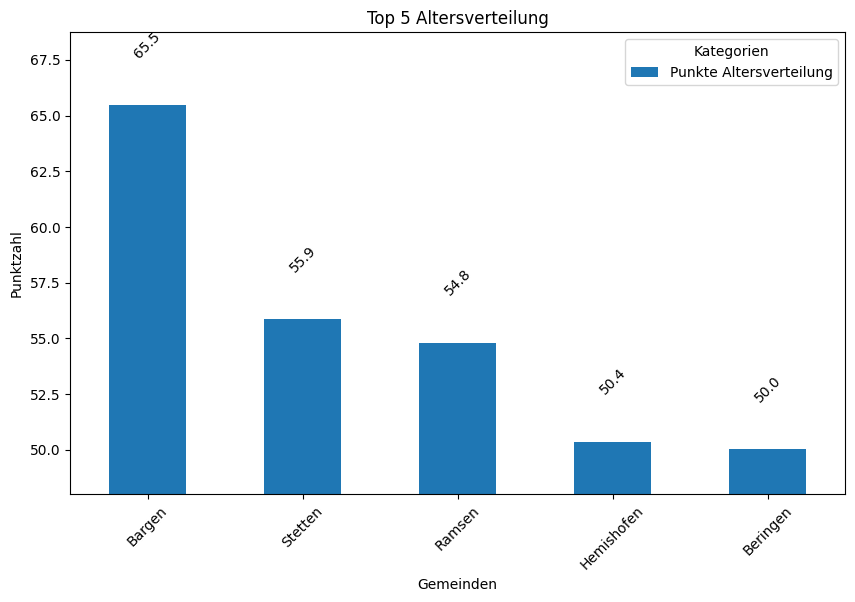

In [6]:
showBarDiagramWithValues(dataframe_population.head().iloc[:, [0,4]], 'Top 5 Altersverteilung', 48)

### Weinstatistiken pro Gemeinde
Die Weinstatistik zeigt auf, welche Gemeinden die grösste Anbaufläche der Rebsorten Blauburgunder (Pinot noir), Chardonnay und Sauvignon blanc aufweisen. Es gilt die Annahme, dass die Gemeinde mit den grössten Anbauflächen auch diese mit dem grössten Konsum sind.

*Quellen*:
- https://sh.ch/CMS/get/file/bb067876-9c87-4df5-afa0-26bb3ba428b1, Seite 11, Jahr 2022: Laden der Rebsorten Anbauflächen pro Gemeinde

In [7]:
# Pfadeingabe zum PDF
pdf_path = "data/Rebbericht_2022_SH_TG_def_2.pdf"

# Lese das PDF in ein Pandas DataFrame ein
dataframe_wine_raw = tabula.read_pdf(pdf_path, pages='all', multiple_tables=True)[2]

# Erzeuge ein DataFrame mit den benötigten Spalten
dataframe_wine_raw = dataframe_wine_raw.iloc[:, [0,1,3,9]]
dataframe_wine_raw.columns = ['Gemeinde', 'Blauburgunder Fläche', 'Chardonnay Fläche', 'Sauvignon blanc Fläche']

# Lösche die erste, letzte und leere Zeilen
dataframe_wine_raw = dataframe_wine_raw.drop(0).reset_index(drop=True)
dataframe_wine_raw = dataframe_wine_raw.drop(len(dataframe_wine_raw)-1).reset_index(drop=True)
dataframe_wine_raw = dataframe_wine_raw.dropna(subset=['Gemeinde']).reset_index(drop=True)

dataframe_wine_raw['Gemeinde'] = dataframe_wine_raw['Gemeinde'].str.replace(" (SH)", '')

# Liste der Spalten, die bearbeitet werden sollen
columns_to_process = ['Blauburgunder Fläche', 'Chardonnay Fläche', 'Sauvignon blanc Fläche']
# Iteriere über die ausgewählten Spalten und führe die Operationen durch
for column in columns_to_process:
    try:
        dataframe_wine_raw[column] = pd.to_numeric(dataframe_wine_raw[column].str.replace('\'', ''), errors='raise')
    except ValueError as e:
        print(f"Error converting column '{column}': {e}")
        
dataframe_wine_raw = dataframe_wine_raw.fillna(0) # Setze 0.0 bei allen undefinierten Werten.

In [8]:
dataframe_wine_calc = pd.merge(dataframe_wine_raw, dataframe_communities, on='Gemeinde', how='right').iloc[:, [0,1,2,3]]

# Berechne die Punkte pro Feature
dataframe_wine_calc = calculatePointsForColumns(dataframe_wine_calc, dataframe_wine_calc.columns[1:4])

# Berechne die Anzahl Punkte pro Gemeinde mit der Gewichtung Burgunder = 50%, Chardonnay = 10%, Sauvignon = 40%
dataframe_wine_calc['Punkte Wein'] = dataframe_wine_calc['Punkte Blauburgunder Fläche'] * 0.5 + dataframe_wine_calc['Punkte Chardonnay Fläche'] * 0.1 + dataframe_wine_calc['Punkte Sauvignon blanc Fläche'] * 0.4

# Bereinigen der Weinstatistik von Schauffhausen
dataframe_wine = cleanUpDataFrameOnColumns(dataframe_wine_calc, [0,4,5,6,7], 'Punkte Wein')

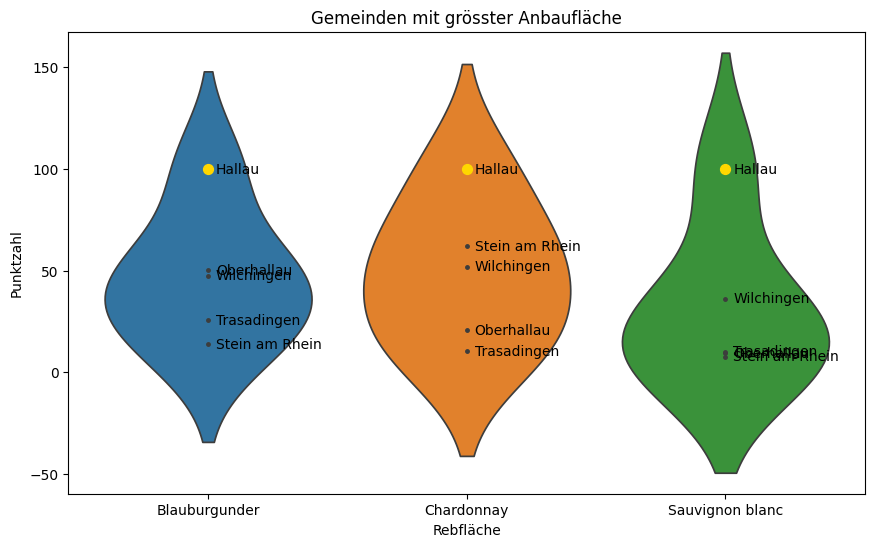

In [9]:
_, violin_diagram_axis = plt.subplots(figsize=(10.28, 6))
violin_diagram_wine = dataframe_wine.head().iloc[:, 1:4]
violin_diagram_wine = violin_diagram_wine.rename(columns={'Punkte Blauburgunder Fläche': 'Blauburgunder', 'Punkte Chardonnay Fläche': 'Chardonnay', 'Punkte Sauvignon blanc Fläche' : 'Sauvignon blanc'})

sns.violinplot(ax=violin_diagram_axis, data=violin_diagram_wine, inner="point")

# Visualisiere das Maximum jeder Kategorie mit einem gelben Punkt
for column in violin_diagram_wine.columns:
    max_index = violin_diagram_wine[column].idxmax()
    violin_diagram_axis.scatter(violin_diagram_wine.columns.get_loc(column), violin_diagram_wine.loc[max_index, column], color='gold', s=50, zorder=5)

# Füge den Gemeinden-Namen für jeden Punkt hinzu
for i in range(len(violin_diagram_wine)):
    for j, column in enumerate(violin_diagram_wine.columns):
        # Setze den Gemeinden-Namen neben jeden Punkt
        violin_diagram_axis.text(j + 0.03, violin_diagram_wine.iloc[i, j], dataframe_wine.iloc[i]['Gemeinde'], ha='left', va='center', fontsize=10)

plt.xlabel('Rebfläche')
plt.ylabel('Punktzahl')
plt.title('Gemeinden mit grösster Anbaufläche')
plt.show()

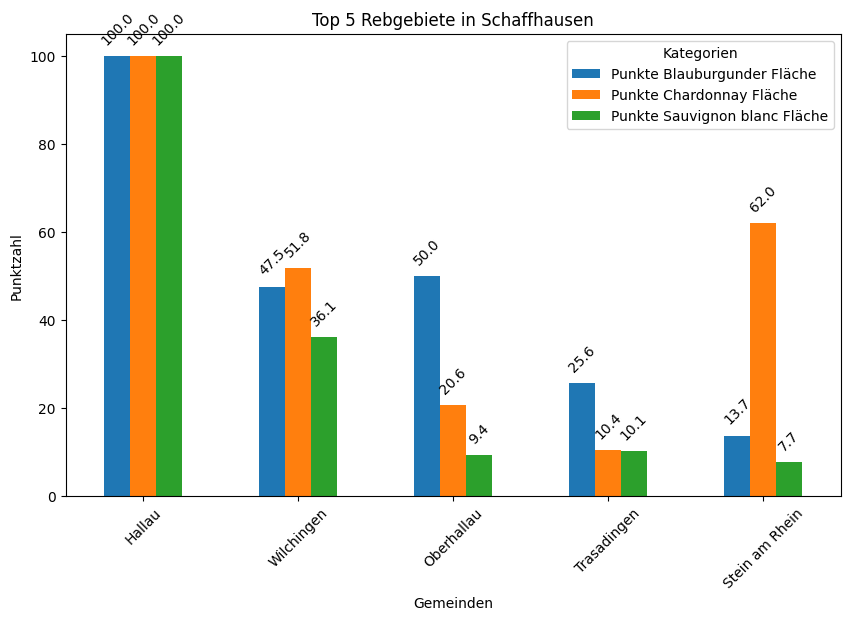

In [10]:
showBarDiagramWithValues(dataframe_wine.head().iloc[:, :4], 'Top 5 Rebgebiete in Schaffhausen', 0)

Wie unschwer zu erkennen ist, hat die Gemeinde `Hallau` bei allen drei Rebsorten die grösste Anbau Fläche. Wie stark überlegen `Hallau` ist im Gegensatz zu den anderen Gemeinden zeigt auch der violin plot. Die einzelnen schwarzen Punkte stehen für Anbaufläche einer Gemeinde, dabei ist zu erkennen, dass `Hallau` einen grossen Abstand zu den anderen vier Gemeinden aufweist.

### Bildungslast Statistik pro Gemeinde

Diese Statistik zeigt auf, welche Gemeinden die tiefste Bildungslast in Franken pro Einwohner aufweist. Dabei werden die Jahre 2016, 2014 und 2012 verglichen. Je tiefer die Bildungslast ist, desto besser unter der Annahme, dass die Gemeinde mit der tiefsten Last auch die ist bei welcher am meisten Geld eingespart werden kann.

Bildungslast: Es gibt Ausgaben, die eine Gemeinde kaum beeinflussen kann. Etwa wenn viele Kinder in die Schule kommen. 

*Quellen*:
- https://sh.ch/CMS/get/file/988d765c-07c2-4983-9eca-cdee5c06fa57, Jahr 2017: Laden der Bildungslast in Franken / Einwohner pro Gemeinde. 

In [11]:
excel_path = "data/Bildungslast 7.12.xls"

sheet_name = "7.12"
start_row = 8
end_row = 42

# Lese den definierten Bereich in das DataFrame
dataframe_education_raw = pd.read_excel(excel_path, sheet_name=sheet_name, skiprows=range(1, start_row))

# Lade ausschliesslich die benötigten Spalten
dataframe_education_raw = dataframe_education_raw.iloc[0:end_row-start_row]
dataframe_education_raw = dataframe_education_raw.iloc[:, [0,10,12,14]]
dataframe_education_raw.columns = ['Gemeinde', '2012 pro Einwohner (CHF)', '2014 pro Einwohner (CHF)', '2016 pro Einwohner (CHF)']

# Entferne Zeilen, welche keine Einträge aufweisen im Jahr 2016
dataframe_education_raw = dataframe_education_raw.dropna(subset=['2016 pro Einwohner (CHF)']).reset_index(drop=True)
dataframe_education_raw = dataframe_education_raw.sort_values(by='2016 pro Einwohner (CHF)', ascending=False)

In [12]:
dataframe_education_calc = pd.merge(dataframe_education_raw, dataframe_communities, on='Gemeinde', how='inner').iloc[:, [0,1,2,3]]

# Berechne die Punkte pro Feature
dataframe_education_calc = calculatePointsForColumns(dataframe_education_calc, dataframe_education_calc.columns[1:4])

# Die berechnete Punkte sind noch so berechnet, dass die Gemeinde mit den höchsten Ausgaben an erster Stelle steht. Somit müssen die Punkte noch umgerechnet werden
education_point_columns = dataframe_education_calc.columns[4:7]
dataframe_education_calc[education_point_columns] = 100 - dataframe_education_calc[education_point_columns]

# Berechne die Anzahl Punkte pro Gemeinde mit der Gewichtung 2012 = 10%, 2014 = 30%, 2016 = 60%
dataframe_education_calc['Punkte Bildung'] = (dataframe_education_calc['Punkte 2012 pro Einwohner (CHF)'] * 0.1 + dataframe_education_calc['Punkte 2014 pro Einwohner (CHF)'] * 0.3 + dataframe_education_calc['Punkte 2016 pro Einwohner (CHF)'] * 0.6)

# Bereinigen der Bildungsstatistik von Schauffhausen
dataframe_education = cleanUpDataFrameOnColumns(dataframe_education_calc, [0,4,5,6,7], 'Punkte Bildung')

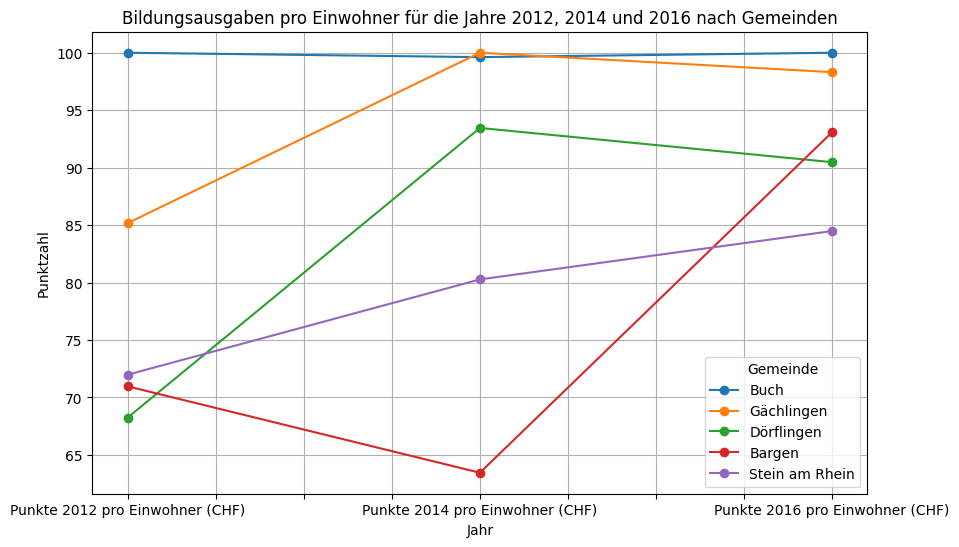

In [13]:
# Visualizierung der TOP 5 Gemeinden der Bildungsstatistik
line_diagram_education = dataframe_education.copy().iloc[:, [0,1,2,3]]

# Setze die Gemeinde als Index und transponiere das DataFrame, um die Gemeinden als Linie darzustellen
line_diagram_education.set_index('Gemeinde', inplace=True)
line_diagram_education = line_diagram_education.head().T

# Plot des Liniendiagramms
plt.rcParams['figure.figsize'] = [10, 6]
line_diagram_education.plot(marker='o')
plt.ylabel('Punktzahl')
plt.xlabel('Jahr')
plt.title('Bildungsausgaben pro Einwohner für die Jahre 2012, 2014 und 2016 nach Gemeinden')
plt.legend(title='Gemeinde')
plt.grid(True)
plt.show()

Die obige Grafik visualisiert den Bildungslast Verlauf der Top 5 Gemeinden in dieser Statistik. Daraus kann man ableiten, dass `Buch` die tiefste Bildungslast pro Einwohner aufweist. Heisst, diese Gemeinde kann bezüglich der Bildung am meisten Geld einsparen.

### Zusammenführung der drei Ranglisten
Nachfolgend werden alle drei Ranglisten zusammengeführt und die Top 5 der jeweiligen Rangliste in einem Balkendiagramm darstellt. Die Sortierung nach Kategorie kann entsprechend angepasst werden.

Mögliche Parameter = 'Punkte Altersverteilung', 'Punkte Wein', 'Punkte Bildung'

In [14]:
# Zusammenführen der drei DataFrames der Ranglisten
sortBy = 'Punkte Wein'

dataframe_all_rankings = pd.merge(pd.merge(dataframe_wine, dataframe_population, on='Gemeinde', how='inner'), dataframe_education, on='Gemeinde', how='inner'
                    ).iloc[:, [0,4,8,12]].sort_values(by=sortBy, ascending=False)

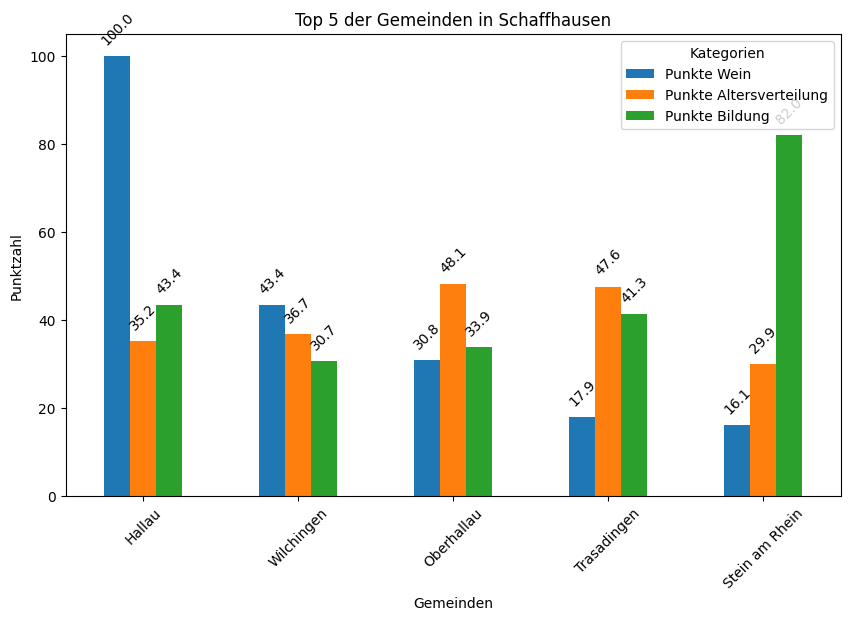

In [15]:
showBarDiagramWithValues(dataframe_all_rankings.head(), 'Top 5 der Gemeinden in Schaffhausen', 0)